# Read and visualise CoLoRe's output
This is a notebook to read example output from CoLoRe and make some basic plots showing the QSO distributions and the skewers.

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from lyacolore import utils

## Open an example data file and show its structure.
Here, there is a choice between a Gaussian output file, or a 2LPT (density) one. Set the variable `file_type` to `gaussian` or `2lpt` to make your choice.

The HDUs contain the following information:

 - `CATALOG` contains information about the QSOs.
 - `DENSITY` contains the density skewers. Skewers are stored as an array, where each row corresponds to a separate skewer.
 - `VELOCITY` contains the velocity skewers. Skewers are stored as an array, where each row corresponds to a separate skewer.
 - The 4th HDU contains cosmological quantities (redshift, comoving distance etc) along the skewers.

In [2]:
file_type = 'gaussian'

In [3]:
assert file_type in ['gaussian','2lpt']

In [4]:
hdulist = fits.open(os.environ['LYACOLORE_PATH']
                    +'/example_data/{}/colore_output/out_srcs_s1_0.fits'.format(file_type))
hdulist.info()

Filename: //Users/James/Projects/LyaCoLoRe//example_data/gaussian/colore_output/out_srcs_s1_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  CATALOG       1 BinTableHDU     25   1000R x 5C   [1J, 1E, 1E, 1E, 1E]   
  2  DENSITY       1 ImageHDU         9   (2048, 1000)   float32   
  3  VELOCITY      1 ImageHDU         9   (2048, 1000)   float32   
  4                1 BinTableHDU     22   2048R x 4C   [1E, 1E, 1E, 1E]   


## Take a look at the QSOs in the file.

In [5]:
z_qso = hdulist[1].data['Z_COSMO']
N_qso = len(z_qso)
print('There are {} quasars in the sample.'.format(N_qso))

There are 1000 quasars in the sample.


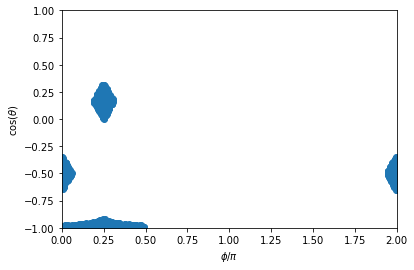

In [6]:
# Plot the locations of the quasars.
RA = hdulist[1].data['RA']
DEC = hdulist[1].data['DEC']
phi = RA*np.pi/180
theta = np.pi/2 - DEC*np.pi/180
plt.scatter(phi/np.pi,np.cos(theta))
plt.xlim(0.0,2.0)
plt.ylim(-1.0,1.0)
plt.xlabel(r'$\phi/\pi$')
plt.ylabel(r'$\cos(\theta)$')
plt.show()

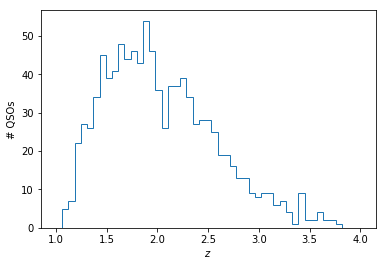

In [7]:
# Plot the n(z) distribution of the quasars.
bins = np.linspace(1.0,4.0,50)
zqso = hdulist[1].data['Z_COSMO']
plt.hist(zqso,bins=bins,histtype='step')
plt.xlabel(r'$z$')
plt.ylabel('# QSOs')
plt.show()

## Extract some general data from the file.

In [8]:
# Extract redshift from data file
z = hdulist[4].data['Z']
z = np.asarray(z)

In [9]:
# Extract the delta skewers from the file, and make a mask for them according to a maximum rest frame wavelength.
lr_max = 1200.
delta_skewers = hdulist[2].data
mask = utils.make_IVAR_rows(lr_max,z_qso,np.log10(utils.lya_rest*(1+z)))

## Look at an individual skewer.

In [10]:
# Get the skewer for the highest redshift quasar in the sample.
ind = np.argmax(hdulist[1].data['Z_COSMO'])
delta = delta_skewers[ind,:]

mean delta = -0.029170379
std delta = 1.2111038114013866


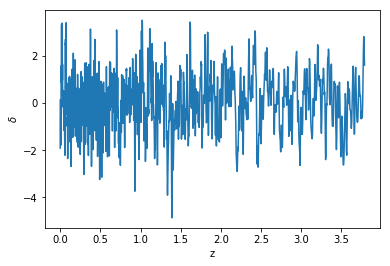

In [11]:
#Show delta vs z
mean_delta = np.average(delta,weights=mask[ind])
print('mean delta =', mean_delta)
mean_delta_squared = np.average(delta**2,weights=mask[ind])
sigma_delta = np.sqrt(mean_delta_squared-mean_delta**2)
print('std delta =', sigma_delta)
plt.figure()
plt.plot(z,delta)
plt.xlabel('z')
plt.ylabel('$\\delta$')
plt.show()

## Look at the mean and std of all skewers in the file.

mean delta over all skewers = 0.009103324


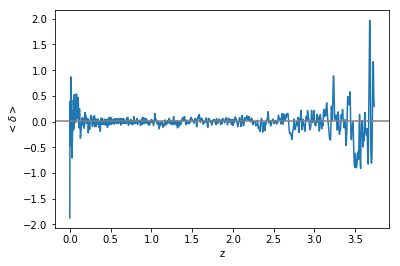

In [12]:
# Plot the mean as a function of redshift.
overall_mean_delta = np.average(delta_skewers,weights=mask)
print('mean delta over all skewers =', overall_mean_delta)
w = mask.sum(axis=0)>0
plt.plot(z[w],np.average(delta_skewers[:,w],weights=mask[:,w],axis=0))
plt.xlabel('z')
plt.ylabel('$<\\delta>$')
plt.axhline(y=overall_mean_delta,c='grey')
plt.show()

std over all skewers = 1.1618


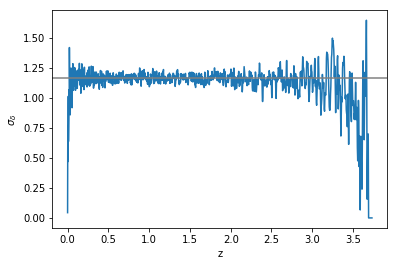

In [13]:
# Plot the standard deviation as a function of redshift.
#Show delta vs z
overall_mean_delta = np.average(delta_skewers,weights=mask)
overall_mean_delta_squared = np.average(delta_skewers**2,weights=mask)
overall_sigma_delta = np.sqrt(overall_mean_delta_squared-overall_mean_delta**2)
print(r'std over all skewers = {:1.4f}'.format(overall_sigma_delta))
w = mask.sum(axis=0)>0
mean_delta = np.average(delta_skewers[:,w],weights=mask[:,w],axis=0)
mean_delta_squared = np.average(delta_skewers[:,w]**2,weights=mask[:,w],axis=0)
plt.plot(z[w],np.sqrt(mean_delta_squared-mean_delta**2))
plt.xlabel('z')
plt.ylabel('$\sigma_{\delta}$')
plt.axhline(y=overall_sigma_delta,c='grey')
plt.show()

## Look at the pdf of the skewers in redshift bins.

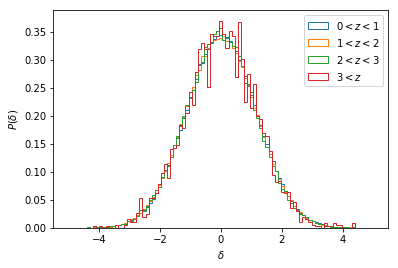

In [14]:
# Plot the pdf of deltas in redshift bins.
z_bins = [(0,1),(1,2),(2,3),(3,)]
if file_type == 'gaussian':
    d_bins = np.linspace(-5,5,100)
elif file_type == '2lpt':
    d_bins = np.linspace(-1,4,100)

for i,zbin in enumerate(z_bins):
    
    if len(zbin)==2:
        w = ((z>zbin[0]) * (z<zbin[1]))
        label = r'${}<z<{}$'.format(zbin[0], zbin[1])
    else:
        w = ((z>zbin[0]))
        label = r'${}<z$'.format(zbin[0])

    plt.hist(np.ravel(hdulist[2].data[:,w]),bins=d_bins,weights=np.ravel(mask[:,w]),
             density=True,histtype='step',label=label)

plt.xlabel('$\\delta$')
plt.ylabel('$P(\delta)$')

plt.legend()
plt.show()